In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
%matplotlib inline

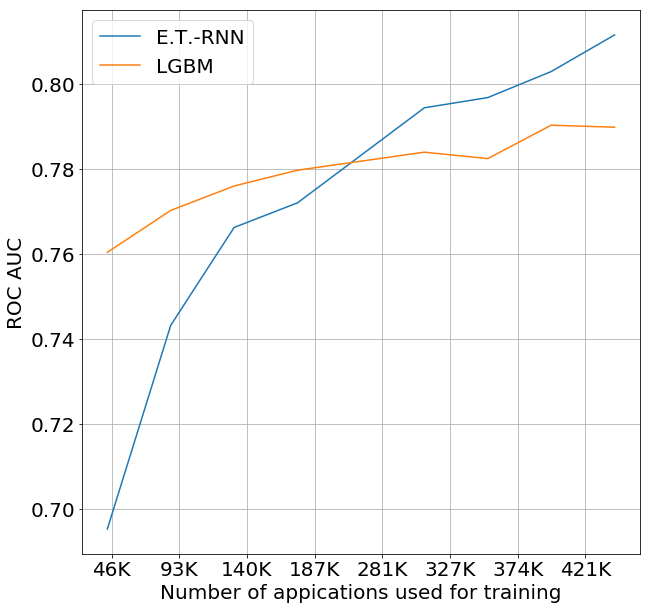

In [6]:
with mpl.rc_context() as rc:
    mpl.rc('font', size=20)
    mpl.rc('savefig', pad_inches=0)

    rnn_lc = pd.read_csv('data/rnn-learning-curve.csv', index_col='n_samples', squeeze=True, header=None, names=['n_samples', 'E.T.-RNN'])
    lgbm_lc = pd.read_csv('data/lgbm-learning-curve.csv', index_col='n_samples', squeeze=True, header=None, names=['n_samples', 'LGBM'])
    lc = pd.DataFrame([rnn_lc, lgbm_lc]).T
    ax = lc.plot(figsize=(10,10), grid=True)
    ax.set_ylabel('ROC AUC')
    ax.set_xlabel('Number of appications used for training')
    ax.set_xticklabels(['0'] + [f'{n}K' for n in (rnn_lc.index // 1000)])
    
    mpl.pyplot.savefig('learning-curve.png', bbox_inches='tight')

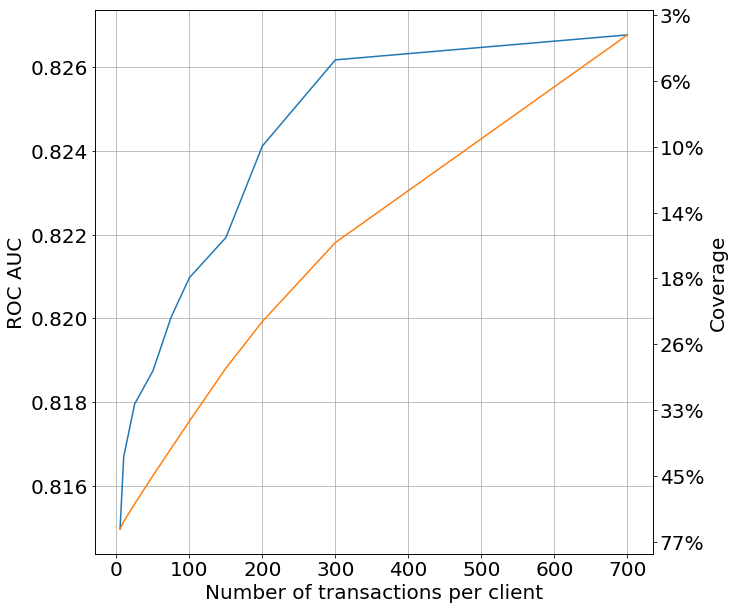

In [12]:
with mpl.rc_context() as rc:
    mpl.rc('font', size=20)

    lc = pd.read_csv('data/rnn-min-max-share-cutoff.csv', index_col='cutoff')
    lc = lc.drop([500, 600])
    lc['coverage'] = 1 - lc.share
    lc = lc.drop([400, 800]).drop('share', axis=1)

    ax = lc['max_roc_auc'].plot(figsize=(10,10), grid=True)
    ax.set_ylabel('ROC AUC')

    #ax2 = ax.twinx()
    ax2 = lc['coverage'].plot(ax=ax, figsize=(10,10), secondary_y=True, grid=True)
    ax2.set_ylabel('Coverage')
    ax.set_xlabel('Number of transactions per client')
    ax2.set_yticklabels(['0'] + [f'{n:.0f}%' for n in (lc.coverage * 100)][::-1])

    mpl.pyplot.savefig('figures/information-vs-accuracy-max.png', bbox_inches='tight')

In [6]:
stats = pd.read_json('article-stats.json').query('n_epoch == 10 and ensemble_size in (1, 3, 6, 12)')

In [7]:
tl = stats.metrics.map(lambda e: e['valid_auc'])
tl_es = [(i, e, es) for l, es in zip(tl.tolist(), stats.ensemble_size) for i, e in enumerate(l)]
tl_df = pd.DataFrame(tl_es, columns=['epoch', 'loss', 'ens_size'])

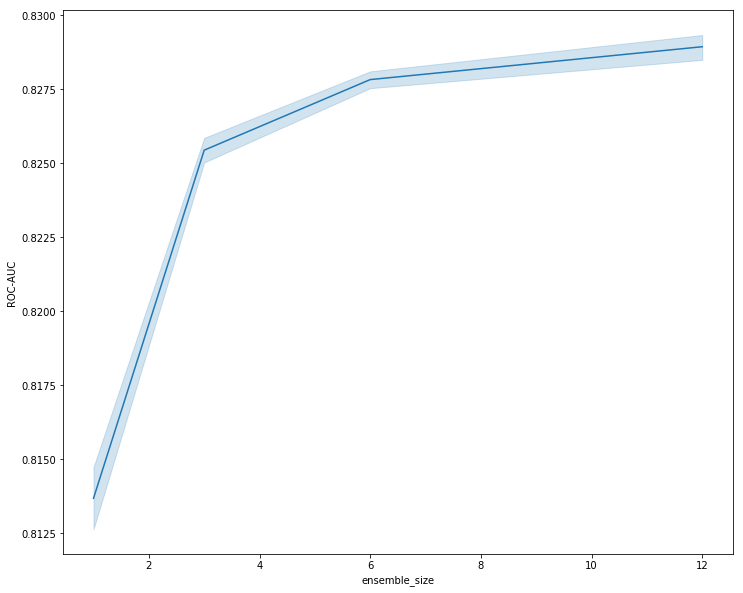

In [8]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.lineplot(x="ensemble_size", y="ROC-AUC", data=stats, legend="full")

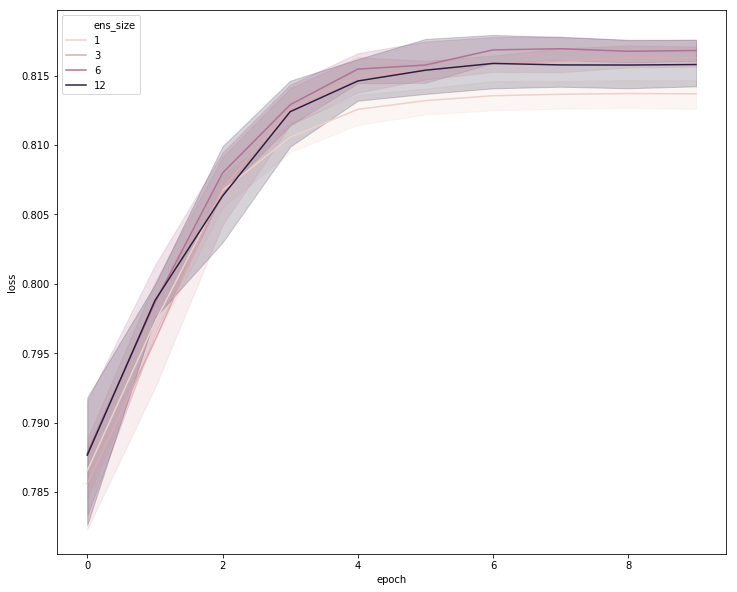

In [9]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.lineplot(x="epoch", y="loss", hue="ens_size", data=tl_df, legend="full")

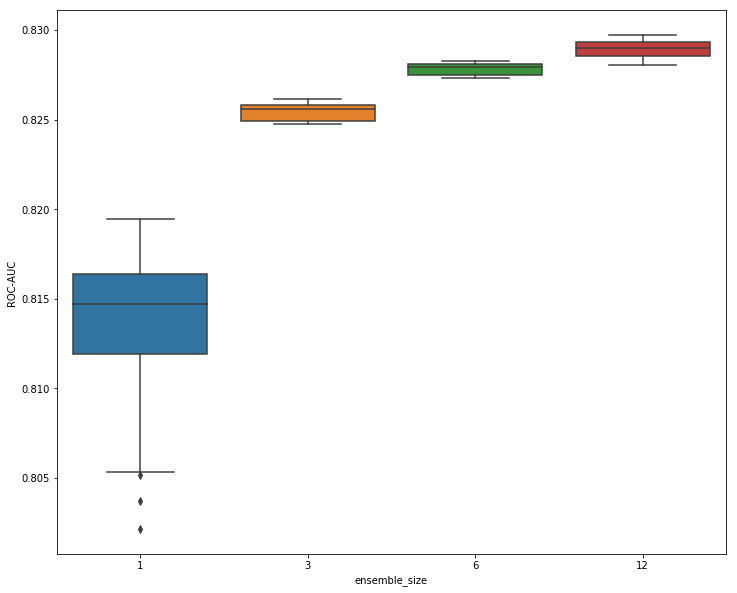

In [10]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.boxplot(x="ensemble_size", y="ROC-AUC", data=stats)